In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import cv2
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
IMAGE_SIZE = 128
import warnings
warnings.filterwarnings("ignore")

2025-10-05 20:46:52.532201: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759697212.719248      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759697212.781639      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def run_test(model):
    for dirname, _, filenames in os.walk('/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val'):
        for filename in filenames:
            path = os.path.join(dirname, filename)
            if not path.endswith('.jpeg'): #since all jpeg images
                continue
            img = cv2.imread(path)
            img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img/255
            img_tensor = np.expand_dims(img, axis = 0)
            y_pred = model.predict(img_tensor)
            print('IMAGE:', path)
            print('Predicted label:', 'NORMAL' if y_pred < 0.5 else 'PNEUMONIA')
            print('Probability:', y_pred)

In [4]:
ImageGen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    rotation_range=30
)

train_dataset = ImageGen.flow_from_directory(
    '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train',
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=32,
    class_mode='binary'
)

ImageGen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)
val_dataset = ImageGen.flow_from_directory(
    '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test',
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=32,
    class_mode='binary'
)

print(train_dataset.class_indices)
print(val_dataset.class_indices)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}


# Pure CNN

In [5]:
earlyStop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [6]:
model = Sequential([
    Conv2D(128, 3, activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(56, 3, activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(56, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

I0000 00:00:1759697229.964506      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1759697229.965249      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [7]:
with tf.device('/GPU:0'):
    hist = model.fit(x=train_dataset, validation_data=val_dataset, epochs=30, batch_size=32, callbacks=[earlyStop])

Epoch 1/30


I0000 00:00:1759697235.251279     112 service.cc:148] XLA service 0x7cb4a8003fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759697235.251762     112 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1759697235.251783     112 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1759697235.741058     112 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/163 ━━━━━━━━━━━━━━━━━━━━ 23:11 9s/step - accuracy: 0.2812 - loss: 0.6990

I0000 00:00:1759697239.940435     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 606ms/step - accuracy: 0.7220 - loss: 0.5688 - val_accuracy: 0.6987 - val_loss: 0.5546
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 399ms/step - accuracy: 0.8512 - loss: 0.3462 - val_accuracy: 0.8590 - val_loss: 0.3730
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 400ms/step - accuracy: 0.8905 - loss: 0.2660 - val_accuracy: 0.8910 - val_loss: 0.3028
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 401ms/step - accuracy: 0.8823 - loss: 0.2770 - val_accuracy: 0.8734 - val_loss: 0.3565
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 402ms/step - accuracy: 0.8974 - loss: 0.2330 - val_accuracy: 0.8958 - val_loss: 0.2810
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 405ms/step - accuracy: 0.9061 - loss: 0.2277 - val_accuracy: 0.9038 - val_loss: 0.2609
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 400ms/step - accuracy: 0.9078 - loss: 0.2214 - val_accuracy: 0.8365 - val_loss: 0.3330
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 407ms/step - accuracy: 0.9074 - loss: 0.2198 - va

> Best validation accuracy 90.38% from epoch 6

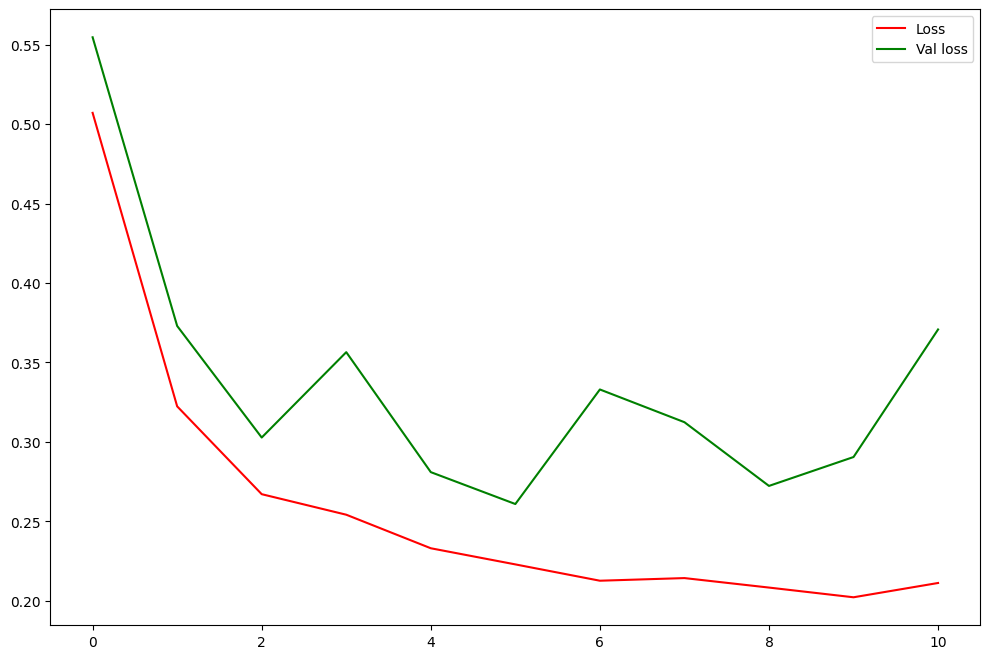

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.plot(range(len(hist.history['loss'])), hist.history['loss'], color='red', label='Loss')
plt.plot(range(len(hist.history['loss'])), hist.history['val_loss'], color='green', label='Val loss')
plt.legend()
plt.show()

In [9]:
run_test(model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
IMAGE: /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
Predicted label: PNEUMONIA
Probability: [[0.98550314]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
IMAGE: /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
Predicted label: PNEUMONIA
Probability: [[0.9958093]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
IMAGE: /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
Predicted label: PNEUMONIA
Probability: [[0.6182674]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
IMAGE: /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
Predicted label: PNEUMONIA
Probability: [[0.88889444]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
IMAGE: /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
Predicted label: PNEUMONIA
Probability: [[0.9960108

> 13/16 test images labeled correctly

# Using MobileNet

In [10]:
mobilenet = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)
mobilenet.trainable = False

mnet_model = Sequential([
    mobilenet,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(56, activation='relu'),
    Dense(1, activation='sigmoid')
])
mnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
with tf.device('/GPU:0'):
    hist = mnet_model.fit(x=train_dataset, validation_data=val_dataset, epochs=30, batch_size=32, callbacks=[earlyStop])

Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 438ms/step - accuracy: 0.8218 - loss: 0.4017 - val_accuracy: 0.8622 - val_loss: 0.3422
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 399ms/step - accuracy: 0.9139 - loss: 0.2064 - val_accuracy: 0.8670 - val_loss: 0.3268
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 396ms/step - accuracy: 0.9305 - loss: 0.1747 - val_accuracy: 0.8462 - val_loss: 0.3474
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 398ms/step - accuracy: 0.9295 - loss: 0.1675 - val_accuracy: 0.8446 - val_loss: 0.3458
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 395ms/step - accuracy: 0.9343 - loss: 0.1680 - val_accuracy: 0.8590 - val_loss: 0.3159
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 393ms/step - accuracy: 0.9413 - loss: 0.1506 - val_accuracy: 0.8622 - val_loss: 0.3125
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 395ms/step - accuracy: 0.9407 - loss: 0.1440 - val_accuracy: 0.8542 - val_loss: 0.3425
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 393ms/step - accuracy: 0.9421 - loss: 0

> Best validation accuracy 87.50% from epoch 23

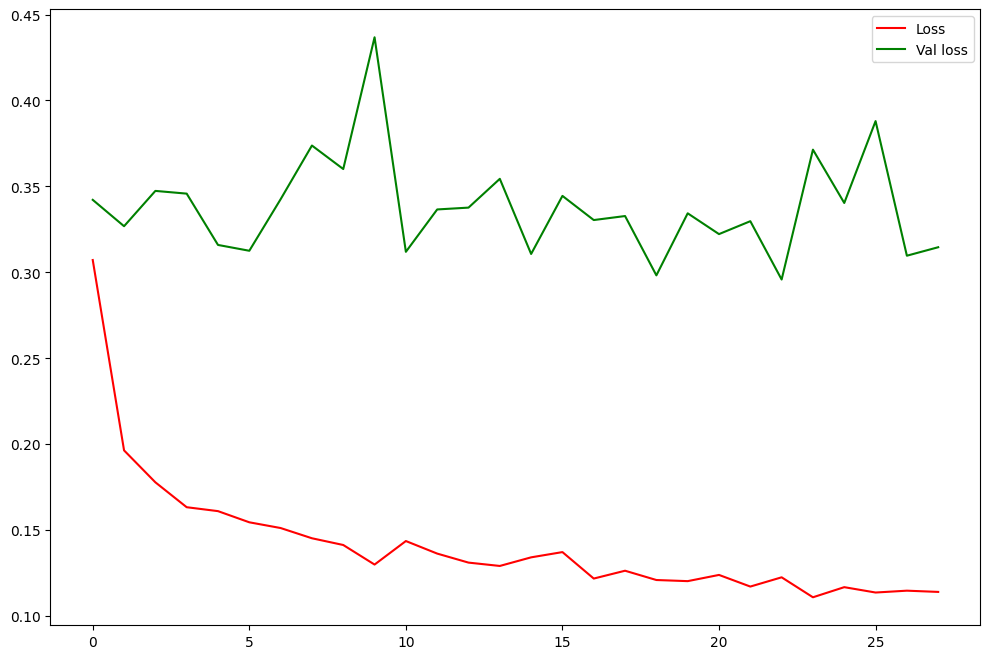

In [12]:
plt.figure(figsize=(12,8))
plt.plot(range(len(hist.history['loss'])), hist.history['loss'], color='red', label='Loss')
plt.plot(range(len(hist.history['loss'])), hist.history['val_loss'], color='green', label='Val loss')
plt.legend()
plt.show()

In [13]:
run_test(mnet_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
IMAGE: /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
Predicted label: PNEUMONIA
Probability: [[0.7890891]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
IMAGE: /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
Predicted label: PNEUMONIA
Probability: [[0.9998373]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
IMAGE: /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
Predicted label: PNEUMONIA
Probability: [[0.96985865]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
IMAGE: /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
Predicted label: PNEUMONIA
Probability: [[0.956574]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
IMAGE: /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
Predicted label: PNEUMONIA
Probability: [[0.9986052]]
1/

> 15/16 test images labeled correctly